<h1>Regression</h1>

In [1]:
import csv
import numpy as np
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

<h2>Laden der Daten</h2>

In [206]:
df_de = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/Sentiment_Analysis/Dataset_DE_Bert_Vader.csv", sep=";",
                parse_dates=["created_at"])

df_de["Date"] = pd.to_datetime(df_de.created_at).apply(lambda x: x.date())
df_de["sentiment_bert"] = df_de["sentiment_bert"].replace(["neutral", "negative", "positive"], ["NEU", "NEG", "POS"])
#df["sentiment_vader"] = df["sentiment_vader"].replace(["0", "-1", "1"], ["NEU", "NEG", "POS"])

In [208]:
df_en = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/Sentiment_Analysis/Dataset_Bert_Vader.csv", sep=";",
                parse_dates=["created_at"])

df_en["Date"] = pd.to_datetime(df_en.created_at).apply(lambda x: x.date())

In [79]:
df_wdi = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/WDI.HM-2.csv", parse_dates=["Date"])

<h2>Vorverarbeitung der Daten</h2>

In [209]:
#Berechnung der Returns f√ºr Log
df_wdi["returns"] = np.log(df_wdi.Close.pct_change() + 1)
df_wdi["returns_2"] = df_wdi.Close.pct_change() + 1
#df_wdi["returns_5"] = df_wdi.Close.pct_change(periods=5) + 1

#Change Date f√ºr df_wdi & df
df_wdi["Date"] = pd.to_datetime(df_wdi.Date).apply(lambda x: x.date())


In [103]:
#Berechnung der Lags
def lagit(df, lags, shifter, drop=False):
    names = []
    for each in shifter:
        for i in range(1, lags+1):
            df["Lag_"+each+"_"+str(i)] = df[each].shift(i)
            names.append("Lag_"+each+"_"+str(i))
    if drop:
        df.dropna(inplace=True)
        df = df.reset_index(drop=True)
    return names, df

In [157]:
#Create a Support DF to calculate all different values, that might be useful.
def sup_df_for_calculations(df_test = df, sentiment = "sentiment_bert"):
    
    
    #Create the support df with the conversation id and the date from the df
    df_sup = df_test[["conversation_id", "Date"]].groupby(by=["Date"]).count().reset_index().rename(columns={"conversation_id": "count_tweets_all"})

    #Add Number of POS Tweets to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "POS"][["tweet_id", "Date"]].groupby(by=["Date"]).count().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"tweet_id": "count_tweets_pos"}).fillna(0)

    #Add Number of NEG Tweets to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "NEG"][["tweet_id", "Date"]].groupby(by=["Date"]).count().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"tweet_id": "count_tweets_neg"}).fillna(0)

    #Add sum of retweet count to DF
    df_sup = df_sup.merge(df_test[["retweet_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"retweet_count": "sum_retweet_all"}).fillna(0)

    #Add sum of POS retweet count to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "POS"][["retweet_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"retweet_count": "sum_retweet_pos"}).fillna(0)

    #Add sum of NEG retweet count to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "NEG"][["retweet_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"retweet_count": "sum_retweet_neg"}).fillna(0)

    #Add sum of liked tweets to DF
    df_sup = df_sup.merge(df_test[["like_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"like_count": "sum_like_all"}).fillna(0)

    #Add sum of POS liked tweets to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "POS"][["like_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"like_count": "sum_like_pos"}).fillna(0)

    #Add sum of NEG liked tweets to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "NEG"][["like_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"like_count": "sum_like_neg"}).fillna(0)

    #Add POS in relation to POS+NEG in percentage
    df_sup["pct_pos"] = df_sup.count_tweets_pos / (df_sup.count_tweets_pos + df_sup.count_tweets_neg)

    #Add NEG in relation to POS+NEG in percentage
    df_sup["pct_neg"] = df_sup.count_tweets_neg / (df_sup.count_tweets_pos + df_sup.count_tweets_neg)

    #Add POS in relation to all tweets in percentage
    df_sup["pct_pos_all"] = df_sup.count_tweets_pos / df_sup.count_tweets_all

    #Add NEG in relation to all tweets in percentage
    df_sup["pct_neg_all"] = df_sup.count_tweets_neg / df_sup.count_tweets_all

    #Add sum of POS tweets, liked and retweets
    df_sup["sum_pos_like_retweet"] = df_sup.count_tweets_pos + df_sup.sum_like_pos + df_sup.sum_retweet_pos

    #Add sum of NEG tweets, liked and retweets
    df_sup["sum_neg_like_retweet"] = df_sup.count_tweets_neg + df_sup.sum_like_neg + df_sup.sum_retweet_neg

    #Add sum of all tweets, liked and retweets
    df_sup["sum_all_like_retweet"] = df_sup.count_tweets_all + df_sup.sum_like_all + df_sup.sum_retweet_all

    #Add pct of POS_sum to NEG_sum and POS_sum
    df_sup["pct_pos_sum"] = df_sup.sum_pos_like_retweet / (df_sup.sum_pos_like_retweet + df_sup.sum_neg_like_retweet)

    #Add pct of NEG_sum to NEG_sum and POS_sum
    df_sup["pct_neg_sum"] = df_sup.sum_neg_like_retweet / (df_sup.sum_pos_like_retweet + df_sup.sum_neg_like_retweet)

    #Add pct of POS_sum to ALL_sum
    df_sup["pct_pos_sum_all"] = df_sup.sum_pos_like_retweet / df_sup.sum_all_like_retweet

    #Add pct of NEG_sum to ALL_sum
    df_sup["pct_neg_sum_all"] = df_sup.sum_neg_like_retweet / df_sup.sum_all_like_retweet

    #Add prod between POS tweets and liked, retweets
    df_sup["prod_pos_like_retweet"] = df_sup.count_tweets_pos * [1 if i == 0 else i for i in (df_sup.sum_like_pos + df_sup.sum_retweet_pos)]

    #Add prod between NEG tweets and liked, retweets
    df_sup["prod_neg_like_retweet"] = df_sup.count_tweets_neg * [1 if i == 0 else i for i in (df_sup.sum_like_neg + df_sup.sum_retweet_neg)]

    #Add prod between all tweets and liked, retweets
    df_sup["prod_all_like_retweet"] = df_sup.count_tweets_all * [1 if i == 0 else i for i in (df_sup.sum_like_all + df_sup.sum_retweet_all)]

    #Add pct of POS_prod to NEG_prod and POS_prod
    df_sup["pct_pos_prod"] = df_sup.prod_pos_like_retweet / (df_sup.prod_pos_like_retweet + df_sup.prod_neg_like_retweet)

    #Add pct of NEG_prod to NEG_prod and POS_prod
    df_sup["pct_neg_prod"] = df_sup.prod_neg_like_retweet / (df_sup.prod_pos_like_retweet + df_sup.prod_neg_like_retweet)

    #Add pct of POS_prod to all_prod
    df_sup["pct_pos_prod_all"] = df_sup.prod_pos_like_retweet / df_sup.prod_all_like_retweet

    #Add pct of NEG_prod to all_prod
    df_sup["pct_neg_prod_all"] = df_sup.prod_neg_like_retweet / df_sup.prod_all_like_retweet
    
    #Add relation of POS and NEG
    df_sup["relation_pos_neg"] = (df_sup["count_tweets_pos"] / df_sup["count_tweets_neg"]).replace(np.inf, np.nan).fillna(0)
    
    #Add relation of NEG and POS
    df_sup["relation_neg_pos"] = (df_sup["count_tweets_neg"] / df_sup["count_tweets_pos"]).replace(np.inf, np.nan).fillna(0)
    
    #Add relation of sum POS and NEG
    df_sup["relation_sum_pos_neg"] = (df_sup["sum_pos_like_retweet"] / df_sup["sum_neg_like_retweet"]).replace(np.inf, np.nan).fillna(0)
    
    #Add relation of sum NEG and POS
    df_sup["relation_sum_neg_pos"] = (df_sup["sum_neg_like_retweet"] / df_sup["sum_pos_like_retweet"]).replace(np.inf, np.nan).fillna(0)
    
    #Add relation of prod POS and NEG
    df_sup["relation_prod_pos_neg"] = (df_sup["prod_pos_like_retweet"] / df_sup["prod_neg_like_retweet"]).replace(np.inf, np.nan).fillna(0)
    
    #Add relation of prod NEG and POS
    df_sup["relation_prod_neg_pos"] = (df_sup["prod_neg_like_retweet"] / df_sup["prod_pos_like_retweet"]).replace(np.inf, np.nan).fillna(0)
    
    #Return the support df
    return df_sup



<h2>Lineare Regression mit Statsmodels</h2>

In [8]:
def regression(df, regressor, output):

    train, test = train_test_split(df, shuffle=False, test_size=0.3, random_state=0)
    
    train_x = train[regressor]
    train_y = train[output]
    
    test_x = test[regressor]
    test_y = test[output]
    
    train_x, train_y = np.array(train_x), np.array(train_y)
    test_x, test_y = np.array(test_x), np.array(test_y)
    
    train_x = sm.add_constant(train_x)
    test_x = sm.add_constant(test_x)
    
    model = sm.OLS(train_y, train_x).fit()
    
    predictions = model.predict(test_x)
    
    print_model = model.summary()
    
    #print(predictions)
    print(print_model)
    return model, predictions, test, test_y

In [163]:
def regression_all(df, regressor, output):
    
    regressor = np.array(df[regressor])

    regressor = sm.add_constant(regressor)

    model = sm.OLS(df[output], regressor).fit()
    
    predictions = model.predict(regressor)
    
    pritn_model = model.summary()

    print(pritn_model)

In [164]:
def test_regression(df, regressor, output, lag_num, train_test = True):
    
    print("=========================", regressor, "=========================\n")
    
    df_wdi_sentiment = create_df(df)
    regressor = [regressor]
    lagnames, df_wdi_sentiment = lagit(df_wdi_sentiment, lag_num, regressor, True)
    
    for each in range(len(lagnames)):
        print("x{each_str}: {lagnames_each}".format(each_str=each+1, lagnames_each=lagnames[each]))
    if train_test:
        reg_model, reg_predictions, test, reg_test_y = regression(df_wdi_sentiment, lagnames, output)
    else:
        regression_all(df_wdi_sentiment, lagnames, output)

In [180]:
def create_df(df, df_wdi = df_wdi):
    df_sentiment = sup_df_for_calculations(df)
    df_wdi_sentiment = df_wdi.merge(df_sentiment.rename(columns={"created_at": "Date"}), how="left", on="Date").fillna(0)
    return df_wdi_sentiment

<h2>Ausf√ºhrung</h2>

In [220]:
regressor = ['Adj Close', 'Volume',
       'returns', 'returns_2', 'count_tweets_all', 'count_tweets_pos',
       'count_tweets_neg', 'sum_retweet_all', 'sum_retweet_pos',
       'sum_retweet_neg', 'sum_like_all', 'sum_like_pos', 'sum_like_neg',
       'pct_pos', 'pct_neg', 'pct_pos_all', 'pct_neg_all',
       'sum_pos_like_retweet', 'sum_neg_like_retweet', 'sum_all_like_retweet',
       'pct_pos_sum', 'pct_neg_sum', 'pct_pos_sum_all', 'pct_neg_sum_all',
       'prod_pos_like_retweet', 'prod_neg_like_retweet',
       'prod_all_like_retweet', 'pct_pos_prod', 'pct_neg_prod',
       'pct_pos_prod_all', 'pct_neg_prod_all', 'relation_pos_neg',
       'relation_neg_pos', 'relation_sum_pos_neg', 'relation_sum_neg_pos',
       'relation_prod_pos_neg', 'relation_prod_neg_pos']
#regressor = ["Adj Close", "Volume"]
output = "returns_2"
lag_num = 5
train_test = False

for each in regressor:
    test_regression(df, each, output, lag_num, train_test)
    print("==================================================\n\n\n")

========================= Adj Close =========================

x1: Lag_Adj Close_1
x2: Lag_Adj Close_2
x3: Lag_Adj Close_3
x4: Lag_Adj Close_4
x5: Lag_Adj Close_5
                            OLS Regression Results                            
Dep. Variable:              returns_2   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     5.323
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           7.66e-05
Time:                        23:55:54   Log-Likelihood:                 1385.2
No. Observations:                1136   AIC:                            -2758.
Df Residuals:                    1130   BIC:                            -2728.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t    

In [128]:
#df_wdi_sentiment[""]
#Regressor that should be used
#regressor = ["pct_pos_all"]#, "bert_pos_percent", "bert_neg_percent", "count_bert_pos", "count_bert_neg"]
regressor = ['count_tweets_all', 'count_tweets_pos',
       'count_tweets_neg', 'sum_retweet_all', 'sum_retweet_pos',
       'sum_retweet_neg', 'sum_like_all', 'sum_like_pos', 'sum_like_neg',
       'pct_pos', 'pct_neg', 'pct_pos_all', 'pct_neg_all',
       'sum_pos_like_retweet', 'sum_neg_like_retweet', 'sum_all_like_retweet',
       'pct_pos_sum', 'pct_neg_sum', 'pct_pos_sum_all', 'pct_neg_sum_all',
       'prod_pos_like_retweet', 'prod_neg_like_retweet',
       'prod_all_like_retweet', 'pct_pos_prod', 'pct_neg_prod',
       'pct_pos_prod_all', 'pct_neg_prod_all']

#Output Variable
output = "Adj Close"

#Name of all Regressores
lagnames = []

#Creates the df_wdi_sentiment
df_wdi_sentiment = create_df(df)

#How many days should be involved in the lag
lag_num = 2

In [154]:
df_wdi_sentiment.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'returns', 'returns_2', 'count_tweets_all', 'count_tweets_pos',
       'count_tweets_neg', 'sum_retweet_all', 'sum_retweet_pos',
       'sum_retweet_neg', 'sum_like_all', 'sum_like_pos', 'sum_like_neg',
       'pct_pos', 'pct_neg', 'pct_pos_all', 'pct_neg_all',
       'sum_pos_like_retweet', 'sum_neg_like_retweet', 'sum_all_like_retweet',
       'pct_pos_sum', 'pct_neg_sum', 'pct_pos_sum_all', 'pct_neg_sum_all',
       'prod_pos_like_retweet', 'prod_neg_like_retweet',
       'prod_all_like_retweet', 'pct_pos_prod', 'pct_neg_prod',
       'pct_pos_prod_all', 'pct_neg_prod_all', 'relation_pos_neg',
       'relation_neg_pos', 'relation_sum_pos_neg', 'relation_sum_neg_pos',
       'relation_prod_pos_neg', 'relation_prod_neg_neg'],
      dtype='object')

In [106]:
#Create the lags
lags, df_wdi_sentiment = lagit(df_wdi_sentiment, lag_num, regressor)
lagnames.extend(lags)
#Create further lags
lags, df_wdi_sentiment = lagit(df_wdi_sentiment, 1, ["returns_2"], True)
lagnames.extend(lags)

In [107]:
for each in range(len(lagnames)):
    print("x{each_str}: {lagnames_each}".format(each_str=each+1, lagnames_each=lagnames[each]))

x1: Lag_count_tweets_all_1
x2: Lag_count_tweets_all_2
x3: Lag_count_tweets_pos_1
x4: Lag_count_tweets_pos_2
x5: Lag_count_tweets_neg_1
x6: Lag_count_tweets_neg_2
x7: Lag_sum_retweet_all_1
x8: Lag_sum_retweet_all_2
x9: Lag_sum_retweet_pos_1
x10: Lag_sum_retweet_pos_2
x11: Lag_sum_retweet_neg_1
x12: Lag_sum_retweet_neg_2
x13: Lag_sum_like_all_1
x14: Lag_sum_like_all_2
x15: Lag_sum_like_pos_1
x16: Lag_sum_like_pos_2
x17: Lag_sum_like_neg_1
x18: Lag_sum_like_neg_2
x19: Lag_pct_pos_1
x20: Lag_pct_pos_2
x21: Lag_pct_neg_1
x22: Lag_pct_neg_2
x23: Lag_pct_pos_all_1
x24: Lag_pct_pos_all_2
x25: Lag_pct_neg_all_1
x26: Lag_pct_neg_all_2
x27: Lag_sum_pos_like_retweet_1
x28: Lag_sum_pos_like_retweet_2
x29: Lag_sum_neg_like_retweet_1
x30: Lag_sum_neg_like_retweet_2
x31: Lag_sum_all_like_retweet_1
x32: Lag_sum_all_like_retweet_2
x33: Lag_pct_pos_sum_1
x34: Lag_pct_pos_sum_2
x35: Lag_pct_neg_sum_1
x36: Lag_pct_neg_sum_2
x37: Lag_pct_pos_sum_all_1
x38: Lag_pct_pos_sum_all_2
x39: Lag_pct_neg_sum_all_1
x4

In [108]:
#Print Summary to Regression based on train and test data.
#This is the Summary for the train data.
reg_model, reg_predictions, test, reg_test_y = regression(df_wdi_sentiment, lagnames, output)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     6.213
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           3.39e-29
Time:                        18:57:09   Log-Likelihood:                -4057.8
No. Observations:                 797   AIC:                             8208.
Df Residuals:                     751   BIC:                             8423.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.9027     58.223      0.428      0.6

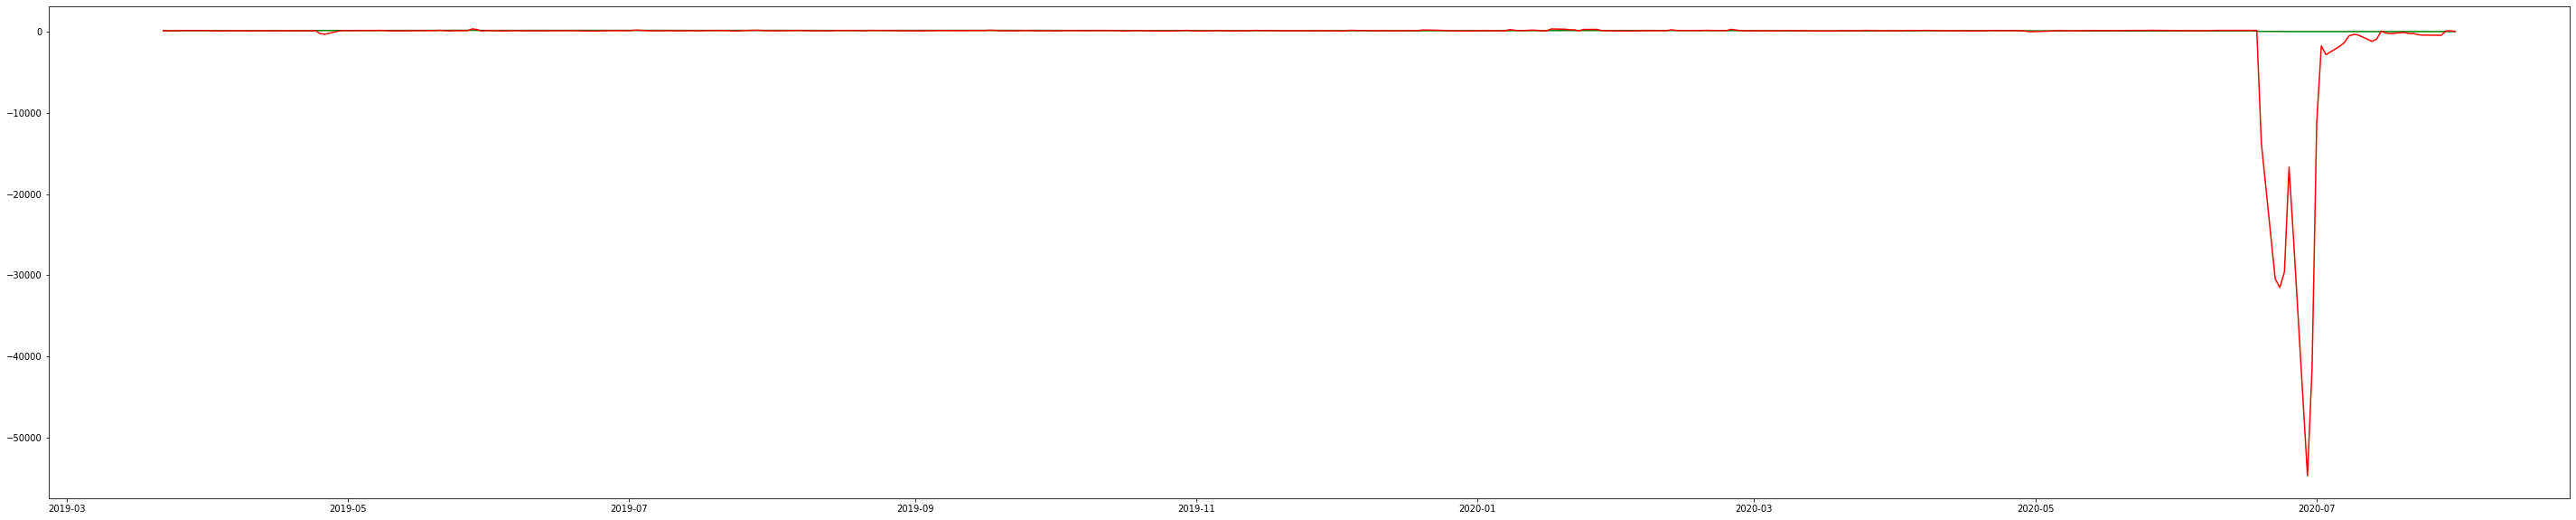

In [46]:
#This Graph plots the predicted values agains the real values in the time perspektive. 
plt.figure(figsize=(50,10))


plt.plot(test["Date"], test[output], color="green")
plt.plot(test["Date"], reg_predictions, color="red")

plt.show()

In [47]:
#Print a second Summary on the trained regression model. 
print(reg_model.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.228    
Dependent Variable: y                AIC:                8207.5948
Date:               2022-09-01 21:58 BIC:                8422.9141
No. Observations:   797              Log-Likelihood:     -4057.8  
Df Model:           45               F-statistic:        6.213    
Df Residuals:       751              Prob (F-statistic): 3.39e-29 
R-squared:          0.271            Scale:              1643.0   
-------------------------------------------------------------------
            Coef.    Std.Err.     t     P>|t|     [0.025    0.975] 
-------------------------------------------------------------------
const       24.9027   58.2232   0.4277  0.6690   -89.3969  139.2024
x1          -0.0352    0.0923  -0.3814  0.7030    -0.2165    0.1461
x2          -0.0108    0.0803  -0.1344  0.8931    -0.1685    0.1469
x3           0.1516    0.2566   0.5910  0.5547    -0.3521    0.6554
x4    

In [48]:
#Calculate the scuared mean squared error on the predicted values based on the real values. 
np.sqrt(mean_squared_error(reg_test_y, reg_predictions))

5062.49057257558

In [49]:
#Calulate the r2 values based on the prediccted and the real values, 
r2_score(reg_test_y, reg_predictions)

-15740.122287495898

In [50]:
for each in range(len(lagnames)):
    print("x{each_str}: {lagnames_each}".format(each_str=each+1, lagnames_each=lagnames[each]))

#Linear Regression over all data without a train and test split. 

all_regressor = np.array(df_wdi_sentiment[lagnames])

all_regressor = sm.add_constant(all_regressor)

all_model = sm.OLS(df_wdi_sentiment[output], all_regressor).fit()
    
all_predictions = all_model.predict(all_regressor)
    
all_print_model = all_model.summary()

print(all_print_model)

x1: Lag_count_tweets_all_1
x2: Lag_count_tweets_all_2
x3: Lag_count_tweets_pos_1
x4: Lag_count_tweets_pos_2
x5: Lag_count_tweets_neg_1
x6: Lag_count_tweets_neg_2
x7: Lag_sum_retweet_all_1
x8: Lag_sum_retweet_all_2
x9: Lag_sum_retweet_pos_1
x10: Lag_sum_retweet_pos_2
x11: Lag_sum_retweet_neg_1
x12: Lag_sum_retweet_neg_2
x13: Lag_sum_like_all_1
x14: Lag_sum_like_all_2
x15: Lag_sum_like_pos_1
x16: Lag_sum_like_pos_2
x17: Lag_sum_like_neg_1
x18: Lag_sum_like_neg_2
x19: Lag_pct_pos_1
x20: Lag_pct_pos_2
x21: Lag_pct_neg_1
x22: Lag_pct_neg_2
x23: Lag_pct_pos_all_1
x24: Lag_pct_pos_all_2
x25: Lag_pct_neg_all_1
x26: Lag_pct_neg_all_2
x27: Lag_sum_pos_like_retweet_1
x28: Lag_sum_pos_like_retweet_2
x29: Lag_sum_neg_like_retweet_1
x30: Lag_sum_neg_like_retweet_2
x31: Lag_sum_all_like_retweet_1
x32: Lag_sum_all_like_retweet_2
x33: Lag_pct_pos_sum_1
x34: Lag_pct_pos_sum_2
x35: Lag_pct_neg_sum_1
x36: Lag_pct_neg_sum_2
x37: Lag_pct_pos_sum_all_1
x38: Lag_pct_pos_sum_all_2
x39: Lag_pct_neg_sum_all_1
x4

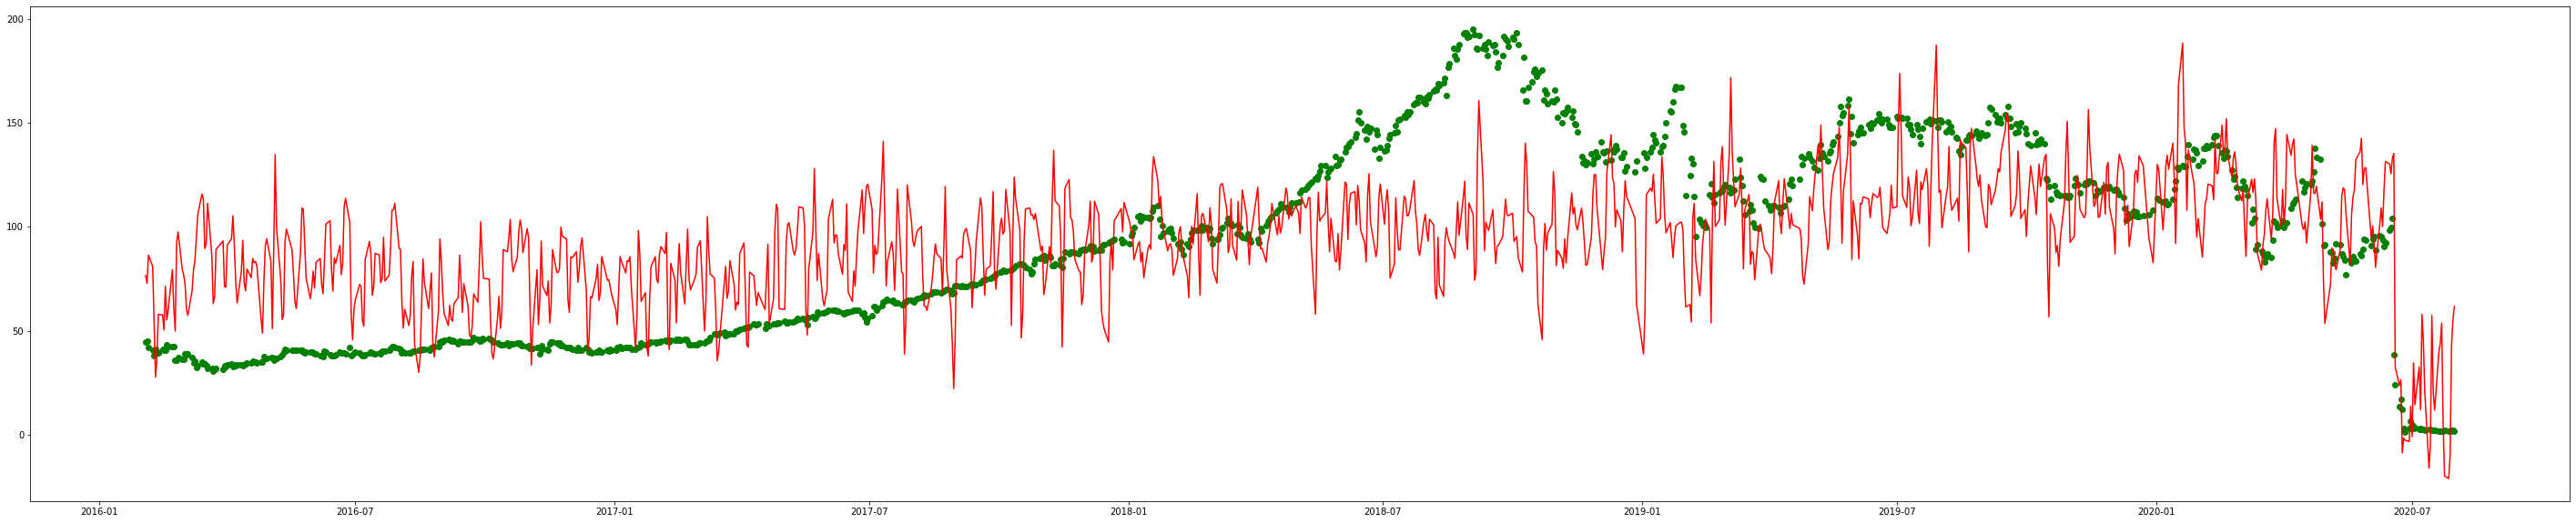

In [51]:
#Print a plot over all values in the regression.
plt.figure(figsize=(50,10))


plt.scatter(df_wdi_sentiment["Date"], df_wdi_sentiment[output], color="green")
plt.plot(df_wdi_sentiment["Date"], all_predictions, color="red")

plt.show()

<h2>Outperform</h2>

In [ ]:
test["direction_LR"] = [1 if i > 0 else -1 for i in reg_predictions]

In [ ]:
test["strat_LR"] = test["direction_LR"] * test["returns"]

In [ ]:
np.exp(test[["returns", "strat_LR"]].sum())

In [ ]:
np.exp(test[["returns", "strat_LR"]].cumsum()).plot()

<h2>Plots for Visualisation</h2>

In [ ]:

plt.scatter(df_wdi_sentiment.Date, np.log(df_wdi_sentiment["Adj Close"]), color="blue")
plt.scatter(df_wdi_sentiment.Date, df_wdi_sentiment.bert_neg_percent_all, color="red")
plt.scatter(df_wdi_sentiment.Date, df_wdi_sentiment.bert_neg_percent, color="orange")


plt.scatter(df_wdi_sentiment.Date, df_wdi_sentiment.bert_pos_percent_all, color="green")


plt.scatter(df_wdi_sentiment.Date, df_wdi_sentiment.bert_pos_percent, color="yellow")


plt.show

In [ ]:
x = np.log(df_wdi_sentiment["bert_pos_percent_all"])
y = np.log(df_wdi_sentiment["Adj Close"])

plt.scatter(x, y)
plt.show()

<h2>Test</h2>

<h3>Testfunktionen und anderes n√ºtzliches </h3>

In [ ]:
def test(df):
    output = ["returns", "intraday_change", "Adj Close"]
    regressor = ["count_bert_pos", "count_bert_neg", "bert_pos_percent_all", "bert_neg_percent_all", 
       "bert_pos_percent", "bert_neg_percent"]
    
    for each_out in output:
        for each_in in regressor:
            df_wdi_sentiment = create_df(df)
            print("===================================",each_out,": ",each_in,"===============================================\n")
            lagnames, df_wdi_sentiment = lagit(df_wdi_sentiment, 5, each_in)
            reg_model, reg_predictions, test = regression(df_wdi_sentiment, lagnames, each_out)
            print("\n\n\n")
    return df_wdi_sentiment
df_wdi_sentiment = test(df)

<h3>Tests zum l√∂schen</h3>

In [ ]:
df_wdi_sentiment["sentiment"] = df_wdi_sentiment["count_bert_pos"] - df_wdi_sentiment["count_bert_neg"]
df_wdi_sentiment["sentiment_dummy"] = [1 if i > 1 else -1 if i < 0 else 0 for i in df_wdi_sentiment["sentiment"]]

In [ ]:
df_sentiment = pd.DataFrame({"created_at": pd.to_datetime(df["created_at"]).apply(lambda x: x.date()), 
                             "tweet_id": df["tweet_id"], 
                             "sentiment_bert": [1 if i == "POS" else 0 if i == "NEU" else -1 for i in df.sentiment_bert],
                             "retweet_count": [1 if i == 0 else i+1 for i in df.retweet_count]}).reset_index(drop=True)
    
df_date_count = pd.DataFrame({"count_tweets": df_sentiment["retweet_count"].groupby(pd.to_datetime(df_sentiment["created_at"]).apply(lambda x: x.date())).sum()}).reset_index()
    
    #Creates a DF for all negativ Values (BERT)
    df_sentiment_neg = df_sentiment.loc[df_sentiment["sentiment_bert"] == -1][["created_at", "retweet_count"]].reset_index(drop=True)
                        
    #Add the information about neg values from bert.
    df_date_count = df_date_count.merge(df_sentiment_neg.groupby(["created_at"]).sum().reset_index().rename(columns={"retweet_count": "count_bert_neg"}),
                                        how="outer", on="created_at").fillna(0)
    #Creates a DF for all positiv Values (BERT)
    df_sentiment_pos = df_sentiment.loc[df_sentiment["sentiment_bert"] == 1][["created_at", "retweet_count"]].reset_index(drop=True)

    #Add the information about pos values from bert.
    df_date_count = df_date_count.merge(df_sentiment_pos.groupby(["created_at"]).sum().reset_index().rename(columns={"retweet_count": "count_bert_pos"}),
                                        how="outer", on="created_at").fillna(0)
    
    #Calculate pos percent
    df_date_count["bert_pos_percent_all"] = df_date_count["count_bert_pos"] / df_date_count["count_tweets"]
    
    #Calculate neg percent
    df_date_count["bert_neg_percent_all"] = df_date_count["count_bert_neg"] / df_date_count["count_tweets"]
    
    #Calculate pos percent
    df_date_count["bert_pos_percent"] = df_date_count["count_bert_pos"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])
    
    #Calculate neg percent
    df_date_count["bert_neg_percent"] = df_date_count["count_bert_neg"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])
    
    #Change Date
    df_date_count = df_date_count.rename(columns={"created_at": "Date"})
    
    return df_date_count

In [ ]:
df_test = df

In [ ]:
df_test["Date"] = pd.to_datetime(df_test.created_at).apply(lambda x: x.date())

In [ ]:
df_test[["conversation_id", "Date"]].groupby(by=["Date"]).count()

In [ ]:
df_test.loc[df_test["sentiment_bert"] == "POS"][["tweet_id", "Date"]].groupby(by=["Date"]).count()

In [ ]:
df_test.loc[df_test["sentiment_bert"] == "POS"][["retweet_count", "Date"]].groupby(by=["Date"]).sum().reset_index()

In [ ]:
df_test.loc[(df_test["Date"] == datetime.date(2016,2,1)) & (df_test["sentiment_bert"] == "POS")]

In [ ]:
df_wdi_test = df_wdi

In [ ]:
#Add Number of Tweets to DF
df_wdi_test = df_wdi_test.merge(df_test[["conversation_id", "Date"]].groupby(by=["Date"]).count().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"conversation_id": "count_tweets"}).fillna(0)

#Add Number of POS Tweets to DF
df_wdi_test = df_wdi_test.merge(df_test.loc[df_test["sentiment_bert"] == "POS"][["tweet_id", "Date"]].groupby(by=["Date"]).count().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"tweet_id": "count_tweets_pos"}).fillna(0)

#Add Number of NEG Tweets to DF
df_wdi_test = df_wdi_test.merge(df_test.loc[df_test["sentiment_bert"] == "NEG"][["tweet_id", "Date"]].groupby(by=["Date"]).count().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"tweet_id": "count_tweets_neg"}).fillna(0)

#Add sum of retweet count to DF
df_wdi_test = df_wdi_test.merge(df_test[["retweet_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"retweet_count": "retweet_count_all"}).fillna(0)

#Add sum of POS retweet count to DF
df_wdi_test = df_wdi_test.merge(df_test.loc[df_test["sentiment_bert"] == "POS"][["retweet_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"retweet_count": "retweet_count_pos"}).fillna(0)

#Add sum of NEG retweet count to DF
df_wdi_test = df_wdi_test.merge(df_test.loc[df_test["sentiment_bert"] == "NEG"][["retweet_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"retweet_count": "retweet_count_neg"}).fillna(0)

#Add sum of liked tweets to DF
df_wdi_test = df_wdi_test.merge(df_test[["like_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"like_count": "like_count_all"}).fillna(0)

#Add sum of POS liked tweets to DF
df_wdi_test = df_wdi_test.merge(df_test.loc[df_test["sentiment_bert"] == "POS"][["like_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"like_count": "like_count_pos"}).fillna(0)

#Add sum of NEG liked tweets to DF
df_wdi_test = df_wdi_test.merge(df_test.loc[df_test["sentiment_bert"] == "NEG"][["like_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"like_count": "like_count_neg"}).fillna(0)

In [ ]:
df_sup = df_test[["conversation_id", "Date"]].groupby(by=["Date"]).count().reset_index().rename(columns={"conversation_id": "count_tweets_all"})

In [ ]:
#Create a Support DF for all calculations

df_sup = df_test[["conversation_id", "Date"]].groupby(by=["Date"]).count().reset_index().rename(columns={"conversation_id": "count_tweets_all"})

#Add Number of POS Tweets to DF
df_sup = df_sup.merge(df_test.loc[df_test["sentiment_bert"] == "POS"][["tweet_id", "Date"]].groupby(by=["Date"]).count().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"tweet_id": "count_tweets_pos"}).fillna(0)

#Add Number of NEG Tweets to DF
df_sup = df_sup.merge(df_test.loc[df_test["sentiment_bert"] == "NEG"][["tweet_id", "Date"]].groupby(by=["Date"]).count().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"tweet_id": "count_tweets_neg"}).fillna(0)

#Add sum of retweet count to DF
df_sup = df_sup.merge(df_test[["retweet_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"retweet_count": "sum_retweet_all"}).fillna(0)

#Add sum of POS retweet count to DF
df_sup = df_sup.merge(df_test.loc[df_test["sentiment_bert"] == "POS"][["retweet_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"retweet_count": "sum_retweet_pos"}).fillna(0)

#Add sum of NEG retweet count to DF
df_sup = df_sup.merge(df_test.loc[df_test["sentiment_bert"] == "NEG"][["retweet_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"retweet_count": "sum_retweet_neg"}).fillna(0)

#Add sum of liked tweets to DF
df_sup = df_sup.merge(df_test[["like_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"like_count": "sum_like_all"}).fillna(0)

#Add sum of POS liked tweets to DF
df_sup = df_sup.merge(df_test.loc[df_test["sentiment_bert"] == "POS"][["like_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"like_count": "sum_like_pos"}).fillna(0)

#Add sum of NEG liked tweets to DF
df_sup = df_sup.merge(df_test.loc[df_test["sentiment_bert"] == "NEG"][["like_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                how="left",
                                on="Date").rename(columns={"like_count": "sum_like_neg"}).fillna(0)

#Add POS in relation to POS+NEG in percentage
df_sup["pct_pos"] = df_sup.count_tweets_pos / (df_sup.count_tweets_pos + df_sup.count_tweets_neg)

#Add NEG in relation to POS+NEG in percentage
df_sup["pct_neg"] = df_sup.count_tweets_neg / (df_sup.count_tweets_pos + df_sup.count_tweets_neg)

#Add POS in relation to all tweets in percentage
df_sup["pct_pos_all"] = df_sup.count_tweets_pos / df_sup.count_tweets_all

#Add NEG in relation to all tweets in percentage
df_sup["pct_neg_all"] = df_sup.count_tweets_neg / df_sup.count_tweets_all

#Add sum of POS tweets, liked and retweets
df_sup["sum_pos_like_retweet"] = df_sup.count_tweets_pos + df_sup.sum_like_pos + df_sup.sum_retweet_pos

#Add sum of NEG tweets, liked and retweets
df_sup["sum_neg_like_retweet"] = df_sup.count_tweets_neg + df_sup.sum_like_neg + df_sup.sum_retweet_neg

#Add sum of all tweets, liked and retweets
df_sup["sum_all_like_retweet"] = df_sup.count_tweets_all + df_sup.sum_like_all + df_sup.sum_retweet_all

#Add pct of POS_sum to NEG_sum and POS_sum
df_sup["pct_pos_sum"] = df_sup.sum_pos_like_retweet / (df_sup.sum_pos_like_retweet + df_sup.sum_neg_like_retweet)

#Add pct of NEG_sum to NEG_sum and POS_sum
df_sup["pct_neg_sum"] = df_sup.sum_neg_like_retweet / (df_sup.sum_pos_like_retweet + df_sup.sum_neg_like_retweet)

#Add pct of POS_sum to ALL_sum
df_sup["pct_pos_sum_all"] = df_sup.sum_pos_like_retweet / df_sup.sum_all_like_retweet

#Add pct of NEG_sum to ALL_sum
df_sup["pct_neg_sum_all"] = df_sup.sum_neg_like_retweet / df_sup.sum_all_like_retweet

#Add prod between POS tweets and liked, retweets
df_sup["prod_pos_like_retweet"] = df_sup.count_tweets_pos * [1 if i == 0 else i for i in (df_sup.sum_like_pos + df_sup.sum_retweet_pos)]

#Add prod between NEG tweets and liked, retweets
df_sup["prod_neg_like_retweet"] = df_sup.count_tweets_neg * [1 if i == 0 else i for i in (df_sup.sum_like_neg + df_sup.sum_retweet_neg)]

#Add prod between all tweets and liked, retweets
df_sup["prod_all_like_retweet"] = df_sup.count_tweets_all * [1 if i == 0 else i for i in (df_sup.sum_like_all + df_sup.sum_retweet_all)]

#Add pct of POS_prod to NEG_prod and POS_prod
df_sup["pct_pos_prod"] = df_sup.prod_pos_like_retweet / (df_sup.prod_pos_like_retweet + df_sup.prod_neg_like_retweet)

#Add pct of NEG_prod to NEG_prod and POS_prod
df_sup["pct_neg_prod"] = df_sup.prod_neg_like_retweet / (df_sup.prod_pos_like_retweet + df_sup.prod_neg_like_retweet)

#Add pct of POS_prod to all_prod
df_sup["pct_pos_prod_all"] = df_sup.prod_pos_like_retweet / df_sup.prod_all_like_retweet

#Add pct of NEG_prod to all_prod
df_sup["pct_neg_prod_all"] = df_sup.prod_neg_like_retweet / df_sup.prod_all_like_retweet



In [ ]:
df_sup

In [ ]:
df_sup.count_tweets_pos * [1 if i == 0 else i for i in (df_sup.sum_like_pos + df_sup.sum_retweet_pos)]

In [ ]:
df_sup.iloc[4]

In [ ]:
count = 0
for each in [1 if i == 0 else i for i in (df_sup.sum_like_pos + df_sup.sum_retweet_pos)]:
    if each == 1:
        count += 1
print(count)

In [ ]:
df_sup.loc[((df_sup.sum_like_pos + df_sup.sum_retweet_pos) == 0) | ((df_sup.sum_like_pos + df_sup.sum_retweet_pos) == 1)]

In [ ]:
df_wdi_test

In [ ]:
df_wdi_test["count_retweet_like_pos"] = df_wdi_test["count_tweets_pos"] * (df_wdi_test["retweet_count_pos"] + df_wdi_test["like_count_pos"])

In [ ]:
df_wdi_test["count_retweet_like_neg"] = df_wdi_test["count_tweets_neg"] * (df_wdi_test["retweet_count_neg"] + df_wdi_test["like_count_neg"])

In [ ]:
df_wdi_test["count_retweet_like"] = df_wdi_test["count_tweets"] * (df_wdi_test["retweet_count_all"] + df_wdi_test["like_count_all"])

In [ ]:
df_wdi_test["pos_per"] = df_wdi_test["count_retweet_like_pos"] / (df_wdi_test["count_retweet_like_neg"] + df_wdi_test["count_retweet_like_pos"])

In [ ]:
df_wdi_test["pos_per_all"] = df_wdi_test["count_retweet_like_pos"] / df_wdi_test["count_retweet_like"]

In [ ]:
df_wdi_test = df_wdi_test.fillna(0)

In [ ]:
df_wdi_test

In [ ]:
df_wdi_test[df_wdi_test.isna().any(axis=1)]

In [ ]:
df_wdi_test[["Date", "retweet_count_pos"]]

In [ ]:
df_test.loc[df_test["Date"] == datetime.date(2016,2,1)]

In [ ]:
df_wdi_test.loc[df_wdi_test["retweet_count_all"] == 0]

In [ ]:
df_wdi_test.loc[(df_wdi_test["like_count_all"] == 0) & (df_wdi_test["retweet_count_all"] == 0)]

In [ ]:
df_test.loc[df_test["Date"] == datetime.date(2016,2,10)]

In [ ]:
df_wdi_test.loc[df_wdi_test["Date"] == datetime.date(2016,2,10)]

<h2>Alte Funktionen und alter Code</h2>

In [ ]:
#add data to df
def calculate_sentiment(df):
    #create a DF with the dates (as dates) and the sum of all tweets grouped by the date
    df_date_count = pd.DataFrame({"count_tweets": df["tweet_id"].groupby(pd.to_datetime(df["created_at"]).apply(lambda x: x.date())).count()}).reset_index()
    
    #create a DF with the dates, tweet_id and the sentiment values cahnges to 1, 0 and -1 for calculating the sum grouped by
    #by the date. 
    df_sentiment = pd.DataFrame({"created_at": pd.to_datetime(df["created_at"]).apply(lambda x: x.date()), 
                                 "tweet_id": df["tweet_id"], 
                                 "sentiment_bert": [1 if i == "POS" else 0 if i == "NEU" else -1 for i in df.sentiment_bert]}).reset_index(drop=True)
    
    #Creates a DF for all negativ Values (BERT)
    df_sentiment_neg = df_sentiment.loc[df_sentiment["sentiment_bert"] == -1][["created_at", "tweet_id"]].reset_index(drop=True)

    #Add the information about neg values from bert.
    df_date_count = df_date_count.merge(df_sentiment_neg.groupby(["created_at"]).count().reset_index().rename(columns={"tweet_id": "count_bert_neg"}),
                                        how="outer", on="created_at").fillna(0)
    #Creates a DF for all positiv Values (BERT)
    df_sentiment_pos = df_sentiment.loc[df_sentiment["sentiment_bert"] == 1][["created_at", "tweet_id"]].reset_index(drop=True)

    #Add the information about pos values from bert.
    df_date_count = df_date_count.merge(df_sentiment_pos.groupby(["created_at"]).count().reset_index().rename(columns={"tweet_id": "count_bert_pos"}),
                                        how="outer", on="created_at").fillna(0)
    
    #Calculate pos percent
    df_date_count["bert_pos_percent_all"] = df_date_count["count_bert_pos"] / df_date_count["count_tweets"]
    
    #Calculate neg percent
    df_date_count["bert_neg_percent_all"] = df_date_count["count_bert_neg"] / df_date_count["count_tweets"]
    
    #Calculate pos percent
    df_date_count["bert_pos_percent"] = df_date_count["count_bert_pos"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])
    
    #Calculate neg percent
    df_date_count["bert_neg_percent"] = df_date_count["count_bert_neg"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])
    
    #Change Date
    df_date_count = df_date_count.rename(columns={"created_at": "Date"})
    
    return df_date_count

In [ ]:
#add data to df 
#In this DF the tweets are not only counted, also the retweet count is used.
def calculate_sentiment(df):    
    #create a DF with the dates, tweet_id and the sentiment values cahnges to 1, 0 and -1 for calculating the sum grouped by
    #by the date. 
    df_sentiment = pd.DataFrame({"created_at": pd.to_datetime(df["created_at"]).apply(lambda x: x.date()), 
                                 "tweet_id": df["tweet_id"], 
                                 "sentiment_bert": [1 if i == "POS" else 0 if i == "NEU" else -1 for i in df.sentiment_bert],
                                 "retweet_count": [1 if i == 0 else i+1 for i in df.retweet_count]}).reset_index(drop=True)
    
    #create a DF with the dates (as dates) and the sum of all tweets grouped by the date
    df_date_count = pd.DataFrame({"count_tweets": df_sentiment["retweet_count"].groupby(pd.to_datetime(df_sentiment["created_at"]).apply(lambda x: x.date())).sum()}).reset_index()
    
    #Creates a DF for all negativ Values (BERT)
    df_sentiment_neg = df_sentiment.loc[df_sentiment["sentiment_bert"] == -1][["created_at", "retweet_count"]].reset_index(drop=True)
                        
    #Add the information about neg values from bert.
    df_date_count = df_date_count.merge(df_sentiment_neg.groupby(["created_at"]).sum().reset_index().rename(columns={"retweet_count": "count_bert_neg"}),
                                        how="outer", on="created_at").fillna(0)
    #Creates a DF for all positiv Values (BERT)
    df_sentiment_pos = df_sentiment.loc[df_sentiment["sentiment_bert"] == 1][["created_at", "retweet_count"]].reset_index(drop=True)

    #Add the information about pos values from bert.
    df_date_count = df_date_count.merge(df_sentiment_pos.groupby(["created_at"]).sum().reset_index().rename(columns={"retweet_count": "count_bert_pos"}),
                                        how="outer", on="created_at").fillna(0)
    
    #Calculate pos percent
    df_date_count["bert_pos_percent_all"] = df_date_count["count_bert_pos"] / df_date_count["count_tweets"]
    
    #Calculate neg percent
    df_date_count["bert_neg_percent_all"] = df_date_count["count_bert_neg"] / df_date_count["count_tweets"]
    
    #Calculate pos percent
    df_date_count["bert_pos_percent"] = df_date_count["count_bert_pos"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])
    
    #Calculate neg percent
    df_date_count["bert_neg_percent"] = df_date_count["count_bert_neg"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])
    
    #Change Date
    df_date_count = df_date_count.rename(columns={"created_at": "Date"})
    
    return df_date_count

In [121]:
(df_wdi_sentiment["count_tweets_pos"] / df_wdi_sentiment["count_tweets_neg"]).replace(np.inf, np.nan).fillna(0)

0       0.000000
1       7.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
1134    0.244898
1135    0.120000
1136    0.281818
1137    0.154930
1138    0.000000
Length: 1139, dtype: float64

In [124]:
(df_wdi_sentiment["sum_pos_like_retweet"] / df_wdi_sentiment["sum_neg_like_retweet"]).replace(np.inf, np.nan).fillna(0)

0       0.000000
1       6.333333
2       0.000000
3       0.000000
4       0.000000
          ...   
1134    0.123822
1135    0.102804
1136    0.123393
1137    0.092593
1138    0.000000
Length: 1139, dtype: float64

In [126]:
(df_wdi_sentiment["prod_pos_like_retweet"] / df_wdi_sentiment["prod_neg_like_retweet"]).replace(np.inf, np.nan).fillna(0)

273.41163244482124

In [188]:
df

conversation_id            author_id                created_at  \
0        703311366262800384           1392131804 2016-02-26 20:11:11+00:00   
1        702405572012974080           1053723204 2016-02-24 08:11:53+00:00   
2        700578193334411264             19811837 2016-02-19 07:10:32+00:00   
3        700221272840601601             19811837 2016-02-18 07:32:15+00:00   
4        697324084221227008            183289696 2016-02-10 07:39:51+00:00   
...                     ...                  ...                       ...   
114439  1164960547693105153           4584354895 2019-08-23 18:00:13+00:00   
114440  1228994498610503680   704753138146877440 2020-02-17 17:53:29+00:00   
114441  1228017316375539712  1138485557502382082 2020-02-13 18:09:16+00:00   
114442  1275070899822059523           1001192245 2020-06-22 14:19:26+00:00   
114443  1271435871364042754            392388185 2020-06-12 13:45:22+00:00   

                   tweet_id lang  retweet_count  reply_count  like_count  \
0        703311366262800384   de              0            0           2   
1        702405572012974080   de              0            0           0   
2        700578193334411264   de              2            0           0   
3        700221272840601601   de              0            0           1   
4        697324084221227008   de              0            0           0   
...                     ...  ...            ...          ...         ...   
114439  1164960547693105153   de              0            0           0   
114440  1229463896425205768   de              0            0           2   
114441  1228018315785838593   de              0            0           0   
114442  1275070899822059523   de              0            0           0   
114443  1271438445500682244   de              0            1           9   

        quote_count              source  tweet_type  referenced_tweet_id  \
0                 0  Twitter Web Client        None                 None   
1                 0  Twitter Web Client        None                 None   
2                 0  Twitter Web Client        None                 None   
3                 0  Twitter Web Client        None                 None   
4                 0             dlvr.it        None                 None   
...             ...                 ...         ...                  ...   
114439            0         tickwatcher        None                 None   
114440            0     Twitter Web App  replied_to  1229459682403725314   
114441            1  Twitter for iPhone  replied_to  1228017316375539712   
114442            0      TalkMarketsApp        None                 None   
114443            0     Twitter Web App  replied_to  1271435871364042754   

                                                     text sentiment_bert  \
0       Wirecard-Chef Markus Braun pumpt irrwitzige Su...        neutral   
1       Jetzt g√ºnstig einsammeln und sp√§ter absahnen? ...        neutral   
2       Wirecard: Was f√ºhrt der Vorstand im Schilde? M...        neutral   
3       Wirecard-Vorstand kauft weiter massiv eigene A...       negative   
4       üìà Wirecard: Serie von Aktienk√§ufen des Vorstan...        neutral   
...                                                   ...            ...   
114439  Top Gainers (&gt;30)UVXY JNUG DRIP OPYGY URR E...       negative   
114440                   1/ Die Anw√§lte der Kl√§gerseit...        neutral   
114441  Ist nicht der WRCDF LV Anteil mit zus√§tzlichen...       negative   
114442  Olaf Scholz - The German Finance Minister Is D...        neutral   
114443   12.06. WDI              29,09 Mio.  +1,16% (v...       negative   

        sentiment_vader  
0                0.0000  
1                0.4871  
2                0.3182  
3                0.0000  
4                0.0000  
...                 ...  
114439           0.5574  
114440           0.0000  
114441           0.0000  
114442           0.0000  
114443           0.1027  

[114444 rows 

In [193]:
df["sentiment_bert"] = df["sentiment_bert"].replace(["neutral", "negative", "positive"], ["NEU", "NEG", "POS"])

In [194]:
df

conversation_id            author_id                created_at  \
0        703311366262800384           1392131804 2016-02-26 20:11:11+00:00   
1        702405572012974080           1053723204 2016-02-24 08:11:53+00:00   
2        700578193334411264             19811837 2016-02-19 07:10:32+00:00   
3        700221272840601601             19811837 2016-02-18 07:32:15+00:00   
4        697324084221227008            183289696 2016-02-10 07:39:51+00:00   
...                     ...                  ...                       ...   
114439  1164960547693105153           4584354895 2019-08-23 18:00:13+00:00   
114440  1228994498610503680   704753138146877440 2020-02-17 17:53:29+00:00   
114441  1228017316375539712  1138485557502382082 2020-02-13 18:09:16+00:00   
114442  1275070899822059523           1001192245 2020-06-22 14:19:26+00:00   
114443  1271435871364042754            392388185 2020-06-12 13:45:22+00:00   

                   tweet_id lang  retweet_count  reply_count  like_count  \
0        703311366262800384   de              0            0           2   
1        702405572012974080   de              0            0           0   
2        700578193334411264   de              2            0           0   
3        700221272840601601   de              0            0           1   
4        697324084221227008   de              0            0           0   
...                     ...  ...            ...          ...         ...   
114439  1164960547693105153   de              0            0           0   
114440  1229463896425205768   de              0            0           2   
114441  1228018315785838593   de              0            0           0   
114442  1275070899822059523   de              0            0           0   
114443  1271438445500682244   de              0            1           9   

        quote_count              source  tweet_type  referenced_tweet_id  \
0                 0  Twitter Web Client        None                 None   
1                 0  Twitter Web Client        None                 None   
2                 0  Twitter Web Client        None                 None   
3                 0  Twitter Web Client        None                 None   
4                 0             dlvr.it        None                 None   
...             ...                 ...         ...                  ...   
114439            0         tickwatcher        None                 None   
114440            0     Twitter Web App  replied_to  1229459682403725314   
114441            1  Twitter for iPhone  replied_to  1228017316375539712   
114442            0      TalkMarketsApp        None                 None   
114443            0     Twitter Web App  replied_to  1271435871364042754   

                                                     text sentiment_bert  \
0       Wirecard-Chef Markus Braun pumpt irrwitzige Su...            NEU   
1       Jetzt g√ºnstig einsammeln und sp√§ter absahnen? ...            NEU   
2       Wirecard: Was f√ºhrt der Vorstand im Schilde? M...            NEU   
3       Wirecard-Vorstand kauft weiter massiv eigene A...            NEG   
4       üìà Wirecard: Serie von Aktienk√§ufen des Vorstan...            NEU   
...                                                   ...            ...   
114439  Top Gainers (&gt;30)UVXY JNUG DRIP OPYGY URR E...            NEG   
114440                   1/ Die Anw√§lte der Kl√§gerseit...            NEU   
114441  Ist nicht der WRCDF LV Anteil mit zus√§tzlichen...            NEG   
114442  Olaf Scholz - The German Finance Minister Is D...            NEU   
114443   12.06. WDI              29,09 Mio.  +1,16% (v...            NEG   

        sentiment_vader  
0                0.0000  
1                0.4871  
2                0.3182  
3                0.0000  
4                0.0000  
...                 ...  
114439           0.5574  
114440           0.0000  
114441           0.0000  
114442           0.0000  
114443           0.1027  

[114444 rows 

In [192]:
df.loc[df["sentiment_bert"] == "positive"]

conversation_id           author_id                created_at  \
19       901512156742635520          2591396858 2017-08-27 02:40:04+00:00   
20       918851482740494337           615451193 2017-10-13 14:58:23+00:00   
21       946791402763096069          1700218045 2017-12-29 17:13:55+00:00   
23       943832495954583552          1545779684 2018-01-22 01:05:50+00:00   
39       945973335258787840  956541991831195650 2018-03-12 22:22:19+00:00   
...                     ...                 ...                       ...   
114276  1278222771449991176  783330773654990849 2020-07-01 07:03:51+00:00   
114320  1278212547330617345            28959003 2020-07-01 06:23:13+00:00   
114325  1278211624936050688          1280049181 2020-07-01 06:19:34+00:00   
114392  1278188922242244611            68658322 2020-07-01 04:49:21+00:00   
114437   902543995385077760           165721718 2017-08-29 14:50:31+00:00   

                   tweet_id lang  retweet_count  reply_count  like_count  \
19       901635397079453697   de              0            0           0   
20       918853427890966528   de              0            1           1   
21       946791402763096069   de              0            0           0   
23       955245082944339970   de              0            0           0   
39       973323326805422081   de              0            0           0   
...                     ...  ...            ...          ...         ...   
114276  1278222771449991176   de              1            0          10   
114320  1278212547330617345   de              0            0           1   
114325  1278211624936050688   de              0            0           0   
114392  1278188922242244611   de              0            0           0   
114437   902543995385077760   de              0            0           0   

        quote_count                      source  tweet_type  \
19                0          Twitter for iPhone  replied_to   
20                0            Tweetbot for Mac  replied_to   
21                0          Twitter Web Client        None   
23                0          Twitter for iPhone  replied_to   
39                0         Twitter for Android  replied_to   
...             ...                         ...         ...   
114276            0          Twitter for iPhone        None   
114320            0             Twitter Web App        None   
114325            0  ConnectedWare TweetApp 1.1        None   
114392            0            Twitter for iPad      quoted   
114437            0                        XING        None   

        referenced_tweet_id  \
19       901534074749235202   
20       918852908548022273   
21                     None   
23       943832495954583552   
39       945973335258787840   
...                     ...   
114276                 None   
114320                 None   
114325                 None   
114392  1278070406172356609   
114437                 None   

                                                     text sentiment_bert  \
19        True. Allgemein all die Verschl√ºsselungsverf...       positive   
20       Braun und Zahnpflege in einem Satz ist schon ...       positive   
21      Bei uns gibt auch internationale Musik. Jetzt ...       positive   
23       üìà Nutze den Moment &amp; handel einfach und s...       positive   
39                                     Freue mich drauf üòè       positive   
...                                                   ...            ...   
114276  Data Morgana, sch√∂nes Wort. Eben im Morningbri...       positive   
114320  Wirecard hat alle Zutaten, um Aktien schlecht ...       positive   
114325  Der  hat gezeigt: auch Aktien die man f√ºr sich...       positive   
114392  Vermutlich k√ºrzeste podcast ever. News des Mon...       positive   
114437  HR Consulting Top Job Stellenangebote -   Verk...       positive   

        sentiment_vader  
19               0.7096  
20               0.0000  
21               0.0000  
23               

In [215]:
df = df_en.append(df_de).reset_index(drop=True)

/var/folders/3r/0dwb2f6j0f39f4r2j9yyjf180000gn/T/ipykernel_49161/3458271465.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_en.append(df_de).reset_index(drop=True)


In [216]:
df

conversation_id            author_id                created_at  \
0        703142204341026818            349287204 2016-02-26 08:58:59+00:00   
1        695255175334924288            428593285 2016-02-04 14:38:45+00:00   
2        695237701386244098             95129352 2016-02-04 13:29:19+00:00   
3        718385114170966016             17616154 2016-04-08 10:28:52+00:00   
4        718384477215567873               546713 2016-04-08 10:26:20+00:00   
...                     ...                  ...                       ...   
222393  1279541597009518592            121158213 2020-07-04 22:24:24+00:00   
222394  1279525520535965696             36842372 2020-07-04 21:20:31+00:00   
222395  1278331510291038215           1212530948 2020-07-04 14:35:50+00:00   
222396  1278553462322671616  1235225464278573056 2020-07-02 04:57:54+00:00   
222397  1278303159455232001            121158213 2020-07-01 12:23:17+00:00   

                   tweet_id lang  retweet_count  reply_count  like_count  \
0        703142204341026818   en              0            0           1   
1        695255175334924288   en              0            0           0   
2        695237701386244098   en              1            0           1   
3        718385114170966016   en              0            0           0   
4        718384477215567873   en              1            0           3   
...                     ...  ...            ...          ...         ...   
222393  1279541597009518592   en              1            0           4   
222394  1279525520535965696   en              1            0           0   
222395  1279423679735255042   en              0            0           0   
222396  1278553462322671616   en              0            0           2   
222397  1278303159455232001   en              0            0           0   

        quote_count              source  tweet_type  referenced_tweet_id  \
0                 0  Twitter Web Client        None                 None   
1                 0               IFTTT        None                 None   
2                 0  Twitter Web Client        None                 None   
3                 0  Twitter Web Client        None                 None   
4                 0  Twitter Web Client        None                 None   
...             ...                 ...         ...                  ...   
222393            0       recurpost.com        None                 None   
222394            0  Twitter for iPhone        None                 None   
222395            0     Twitter Web App  replied_to  1278335952532975616   
222396            0     Twitter Web App        None                 None   
222397            0       recurpost.com        None                 None   

                                                     text sentiment_bert  \
0       1/2 I see Wirecard is rebounding after CEO Mar...            NEU   
1                Thank you for following us Markus Braun!            POS   
2       Disrupt the Banks! (Jeff Stewart, Markus Braun...            NEG   
3       WDI wirecard CEO Markus Braun on Q4 2015 Resul...            NEU   
4       Wirecard Analyst Call transcript is available ...            NEU   
...                                                   ...            ...   
222393  „ã° GOOD QUESTION!!  ‚Ü≥ Why are you paying to be ...            NEU   
222394  Would you invest in AMZN, MSFT,  WRCDF, HTZ or...            NEU   
222395           Is its symbol WRCDF?  Great run on SHOP.            POS   
222396  pcg emerges from Chapter 11This will make a lo...            NEG   
222397  „ã° GOOD QUESTION!!  ‚Ü≥ Why are you paying to be ...            NEU   

        sentiment_vader        Date  
0                0.0992  2016-02-26  
1                0.4199  2016-02-04  
2                0.0000  2016-02-04  
3                0.0000  2016-04-08  
4                0.0000  2016-04-08  
...                 ...         ...  
222393           0.6390  2020-07-04  
222394           0.0000 